In [24]:
import matplotlib.pyplot as plt
#import matplotlib as mpl
from Bio import SeqIO
#import numpy as np
#allows custom colours
from dna_features_viewer import BiopythonTranslator
import pandas as pd
from itertools import cycle

In [25]:
#create a class specifying feature colours
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator iplementing the following theme:
    -Colour promoter in pale green
    -colour exons in dark grey
    -colour introns in light grey
    -colour TFs from colour palette"""

    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    df = pd.read_csv("colourblind_palette.csv", header=0)
    #convert to floats
    floats=df.divide(255)
    #make sets of each row to get the red, green blue colours
    CB_colour_palette = floats.apply(tuple, axis = 1)
    #turn into a list of colour sets
    list_colours = list(CB_colour_palette)
    #make colour iterator
    colour_iterator=cycle(list_colours)
    #change colour cycle
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
    #count = -1
    #set colour count


    def compute_feature_color(self, feature):
        """set colour of each feature"""      

        if feature.type == "promoter":
            return "green"
        elif feature.type == "exon":
            return "darkgrey"
            #return (169,169,169)
        elif feature.type == "intron":
            return "lightgrey"        
            #return (211,211,211)
        elif feature.type == "TFBS":            
            return next(self.colour_iterator)
        else:
            return "gold"

    def compute_feature_box_linewidth(self, feature):
        """change shape of features"""
        return 0

    def compute_feature_label(self, feature):
        """Remove feature labels"""
        #return super().compute_feature_label(feature)
        

    def compute_feature_fontdict(self, feature):
        """change font to arial, size to 10"""
        return dict(family='sans-serif',size=10)
        #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

    #make feature_list so that each feature name is only added once if more than one share the same name
    feature_list = []
    def compute_feature_legend_text(self, feature):
        """add legend if feature label has not been added to legend already"""
        
        if feature.qualifiers.get("label")[0] in self.feature_list:
            pass
        else:
            self.feature_list.append(feature.qualifiers.get("label")[0])
            return feature.qualifiers.get("label")[0]     


    

    def compute_filtered_features(self, features):
        """Do not display features the following features"""
        return [
            feature for feature in features
            if (feature.type != "TRAMP_probe")
            and (feature.type != "none")
            and (feature.type != "DHS")
            and (feature.type != "misc_feature")
            and (feature.type != "primer")
            and (feature.type != "gene")
            ]
        

In [26]:
def gb_file_to_seqrecord(gb_file):
    """load genbankfile into a seqrecord"""
    record = SeqIO.read(gb_file, 'genbank')
    return record

In [27]:
def preprocess_record(seqrecord):
    """Preprocess the biopython record before feeding it into the translator."""
    for feature in seqrecord.features:
        #change strand to None so that features are rectangular
        feature.location.strand = None
        if feature.type == 'TFBS':
            #print(feature)
            #change sigil to box
            feature.qualifiers["sigil"] = 'OCTAGON'            
            #if feature was experimentally validated, add qualifier
            
                       

    return seqrecord



In [28]:
def make_plot(seqrecord, promoter_name):
    #display figure    
    graphic_record = MyCustomTranslator().translate_record(seqrecord)
    #change height to 0 so TFBS can overlap the promoter
    graphic_record.feature_level_height = 0
    #graphic_record = BiopythonTranslator().translate_record(gb_file)
    #make subplots
    fig, (ax1,ax2) = plt.subplots(
        1,2, figsize=(12,4),gridspec_kw={'width_ratios':[1,4]}
    )
    #plot Record Map
    graphic_record.plot(ax=ax2, with_ruler=True)#,figure_width=10, #strand_in_label_threshold=4
    #add legend
    graphic_record.plot_legend(ax=ax1, loc=1, ncol=1, frameon=True)
    #remove axis of legend
    ax1.axis('off')
    fig.tight_layout()
    fig.savefig(f"../../data/TRAMP/plots/{promoter_name}.svg")

In [29]:
def main(args):
    # parse arguments
    #args = parse_args(args)
    #dependent_variable = "GC_content"

    # make directory for the plots to be exported to
    dirName = f"../../data/TRAMP/plots"
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory ", dirName, " created")
    except FileExistsError:
        print("Directory ", dirName, " already exists")

    promoter_name="nlp7-at4g24020-3kbcds0-5kb"
    #file location
    gb_file=f"../../data/TRAMP/{promoter_name}.gb"
    #load seqrecord
    seqrecord = gb_file_to_seqrecord(gb_file)
    #preprocess record
    modified_seqrecord = preprocess_record(seqrecord)
    #make plot
    make_plot(modified_seqrecord, promoter_name)


Directory  ../../data/TRAMP/plots  already exists


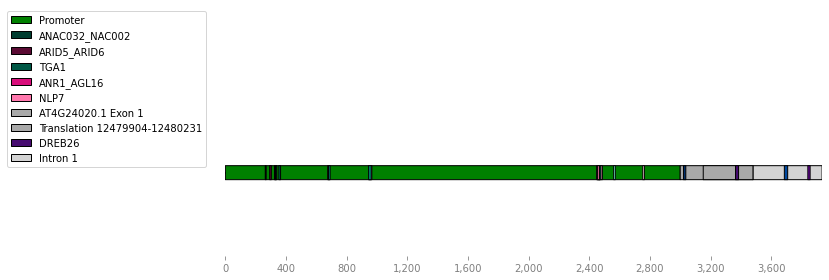

In [30]:
if __name__ == "__main__":
    import sys

    main(sys.argv[1:])